# Data Preparation

In [1]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from notebook_utils import calculate_metrics, eval_metrics, timeseries_rel, trim_extremes
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Historical Data Import

In [3]:
historical = pd.read_csv('../data/kern_polygon_historical.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3549035 entries, 0 to 3549034
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   field_id     object        
 1   crop         int64         
 2   time         datetime64[ns]
 3   actual_et    float64       
 4   actual_eto   float64       
 5   actual_etof  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 162.5+ MB


In [4]:
historical['time'].max()

Timestamp('2024-12-14 00:00:00')

In [5]:
historical['field_id'].nunique()

1085

## Forecast Table Build

In [6]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"../data/forecasts/fret/kern/").glob("*.csv")

for file in files:
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[2].split('.')[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600252 entries, 0 to 3600251
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   field_id          object        
 1   crop              int64         
 2   time              datetime64[ns]
 3   dtw_eto           float64       
 4   fret_eto          float64       
 5   forecasting_date  datetime64[ns]
 6   fret_et           float64       
 7   fret_etof         float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(1)
memory usage: 219.7+ MB


In [7]:
forecasting_table['time'].max()

Timestamp('2024-12-31 00:00:00')

In [8]:
forecasting_table['field_id'].nunique()

1086

## Main Table Merge

In [9]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]
dt = dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt = dt.drop(columns=['actual_et', 'actual_etof', 'fret_et', 'fret_etof'])
dt = dt.dropna(subset=['fret_eto'], how='any')
dt

,forecasting_date,field_id,crop,time,actual_eto,dtw_eto,fret_eto
327,2024-11-22,CA_27267,61,2024-11-23,0.931,1.946,0.980
328,2024-11-22,CA_27267,61,2024-11-24,0.846,1.777,0.890
329,2024-11-22,CA_27267,61,2024-11-25,0.762,1.659,0.800
330,2024-11-22,CA_27267,61,2024-11-26,0.338,1.286,0.740
331,2024-11-22,CA_27267,61,2024-11-27,1.354,1.049,1.040
...,...,...,...,...,...,...,...
3600204,2024-11-11,CA_42345,69,2024-11-14,1.672,1.954,1.337
3600205,2024-11-11,CA_42345,69,2024-11-15,1.760,1.742,1.320
3600206,2024-11-11,CA_42345,69,2024-11-16,1.848,1.602,1.325
3600207,2024-11-11,CA_42345,69,2024-11-17,1.232,1.373,1.277


## Unique Identifiers

In [10]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

# Helpers
Below are functions that are being used to calculate data and generate plots.

The tables below are also calculated prior to speed up metric calculations.

### Average ET/ETo/ETof for 2024
This table will be used as a reference for any metric and plot calculations

In [11]:
avgs_table = pd.read_csv("../data/kern_polygon_historical_2024_avgs.csv.csv")
avgs_table

,field_id,crop,actual_et,actual_eto,actual_etof
0,CA_27267,61,1.879926,2.619126,0.713937
1,CA_297922,75,1.895564,4.543639,0.432794
2,CA_297927,61,2.558662,4.902120,0.563699
3,CA_297932,204,3.683181,4.810393,0.758940
4,CA_297950,204,1.157656,4.531284,0.315994
...,...,...,...,...,...
1080,CA_42273,69,3.910372,4.373481,0.893516
1081,CA_42274,69,2.835905,4.373481,0.683017
1082,CA_42289,47,2.927201,4.387115,0.615739
1083,CA_42338,47,2.661135,4.373613,0.549037


### Climatology Reference
The table below records the average conditions for each field for each day of the year.

In [12]:
climatology_table = pd.read_csv('../data/kern_polygon_historical_climatology.csv')
climatology_table

,field_id,crop,doy,actual_et,actual_eto,actual_etof
0,CA_27267,61,1,0.675000,0.900889,0.739444
1,CA_27267,61,2,0.620444,0.830556,0.739333
2,CA_27267,61,3,0.632111,0.860444,0.739222
3,CA_27267,61,4,0.561111,0.770444,0.738556
4,CA_27267,61,5,0.573444,0.790556,0.737667
...,...,...,...,...,...,...
397105,CA_42345,69,362,0.411750,1.058625,0.398625
397106,CA_42345,69,363,0.415625,1.035250,0.396500
397107,CA_42345,69,364,0.431625,1.070875,0.394625
397108,CA_42345,69,365,0.333500,0.844875,0.393875


# Calculation

In [13]:
analysis_end_date = historical['time'].max()
analysis_end_date

Timestamp('2024-12-14 00:00:00')

Est. run time: 21m

In [14]:
def fret_error_calc(data: pd.DataFrame, **kwargs):
    # Data coming in is a DataFrame for each forecasting_date
    groups = data.groupby(['field_id', 'crop'])[["field_id", "crop", "time", "actual_eto", "fret_eto"]].apply(calculate_metrics, actual="actual_eto", expected="fret_eto", **kwargs).reset_index()

    return groups

In [15]:
dt_mask = dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < (dt['forecasting_date']) + timedelta(days=7)) & (dt['time'] < analysis_end_date)]

In [17]:
metrics_norm = (dt_mask.groupby(['forecasting_date'])[list(dt.columns)]
                .apply(fret_error_calc, normalize=True, climatology_ref=climatology_table, avgs_ref=avgs_table))
metrics_norm.reset_index().to_csv('../data/metrics/kern_fret_metrics_normalized.csv', index=False)

Failed to measure error metrics for field CA_423678 on 2024-09-13 00:00:00
Input contains NaN.
Failed to measure error metrics for field CA_297932 on 2024-09-19 00:00:00
Found input variables with inconsistent numbers of samples: [5, 6]
Failed to measure error metrics for field CA_306627 on 2024-09-19 00:00:00
Found input variables with inconsistent numbers of samples: [5, 6]
Failed to measure error metrics for field CA_423678 on 2024-09-20 00:00:00
Input contains NaN.
Failed to measure error metrics for field CA_301360 on 2024-09-26 00:00:00
Found input variables with inconsistent numbers of samples: [5, 6]
Failed to measure error metrics for field CA_423678 on 2024-09-26 00:00:00
Input contains NaN.
Failed to measure error metrics for field CA_304843 on 2024-11-23 00:00:00
Found input variables with inconsistent numbers of samples: [5, 6]


/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarnin

In [18]:
metrics_norm = pd.read_csv('../data/metrics/kern_fret_metrics_normalized.csv').drop(['level_1'], axis=1)
metrics_norm['forecasting_date'] = pd.to_datetime(metrics_norm['forecasting_date'])

In [19]:
metrics_norm.head()

,forecasting_date,field_id,crop,mae,rmse,corr,bias,skill_score,c_mae,c_bias
0,2024-09-12,CA_27267,61,0.97,1.62,0.53,0.97,-1.00,0.609463,NaN
1,2024-09-12,CA_297922,75,0.12,0.32,0.94,-0.12,0.27,0.662315,NaN
2,2024-09-12,CA_297927,61,0.14,0.40,0.61,-0.13,-0.05,0.750611,NaN
3,2024-09-12,CA_297932,204,0.09,0.25,0.95,-0.09,0.59,0.766000,NaN
4,2024-09-12,CA_297950,204,0.05,0.14,0.96,-0.03,0.84,0.668556,NaN


# Visualization

In [20]:
# First reshape data from wide-form to long-form
metrics_long = metrics_norm.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

In [21]:
# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}
metrics_long['name'] = metrics_long['stat'].map(stat_propers)
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39069 entries, 0 to 39068
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   forecasting_date  39069 non-null  datetime64[ns]
 1   field_id          39069 non-null  object        
 2   crop              39069 non-null  int64         
 3   stat              39069 non-null  object        
 4   value             39048 non-null  float64       
 5   name              39069 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.8+ MB


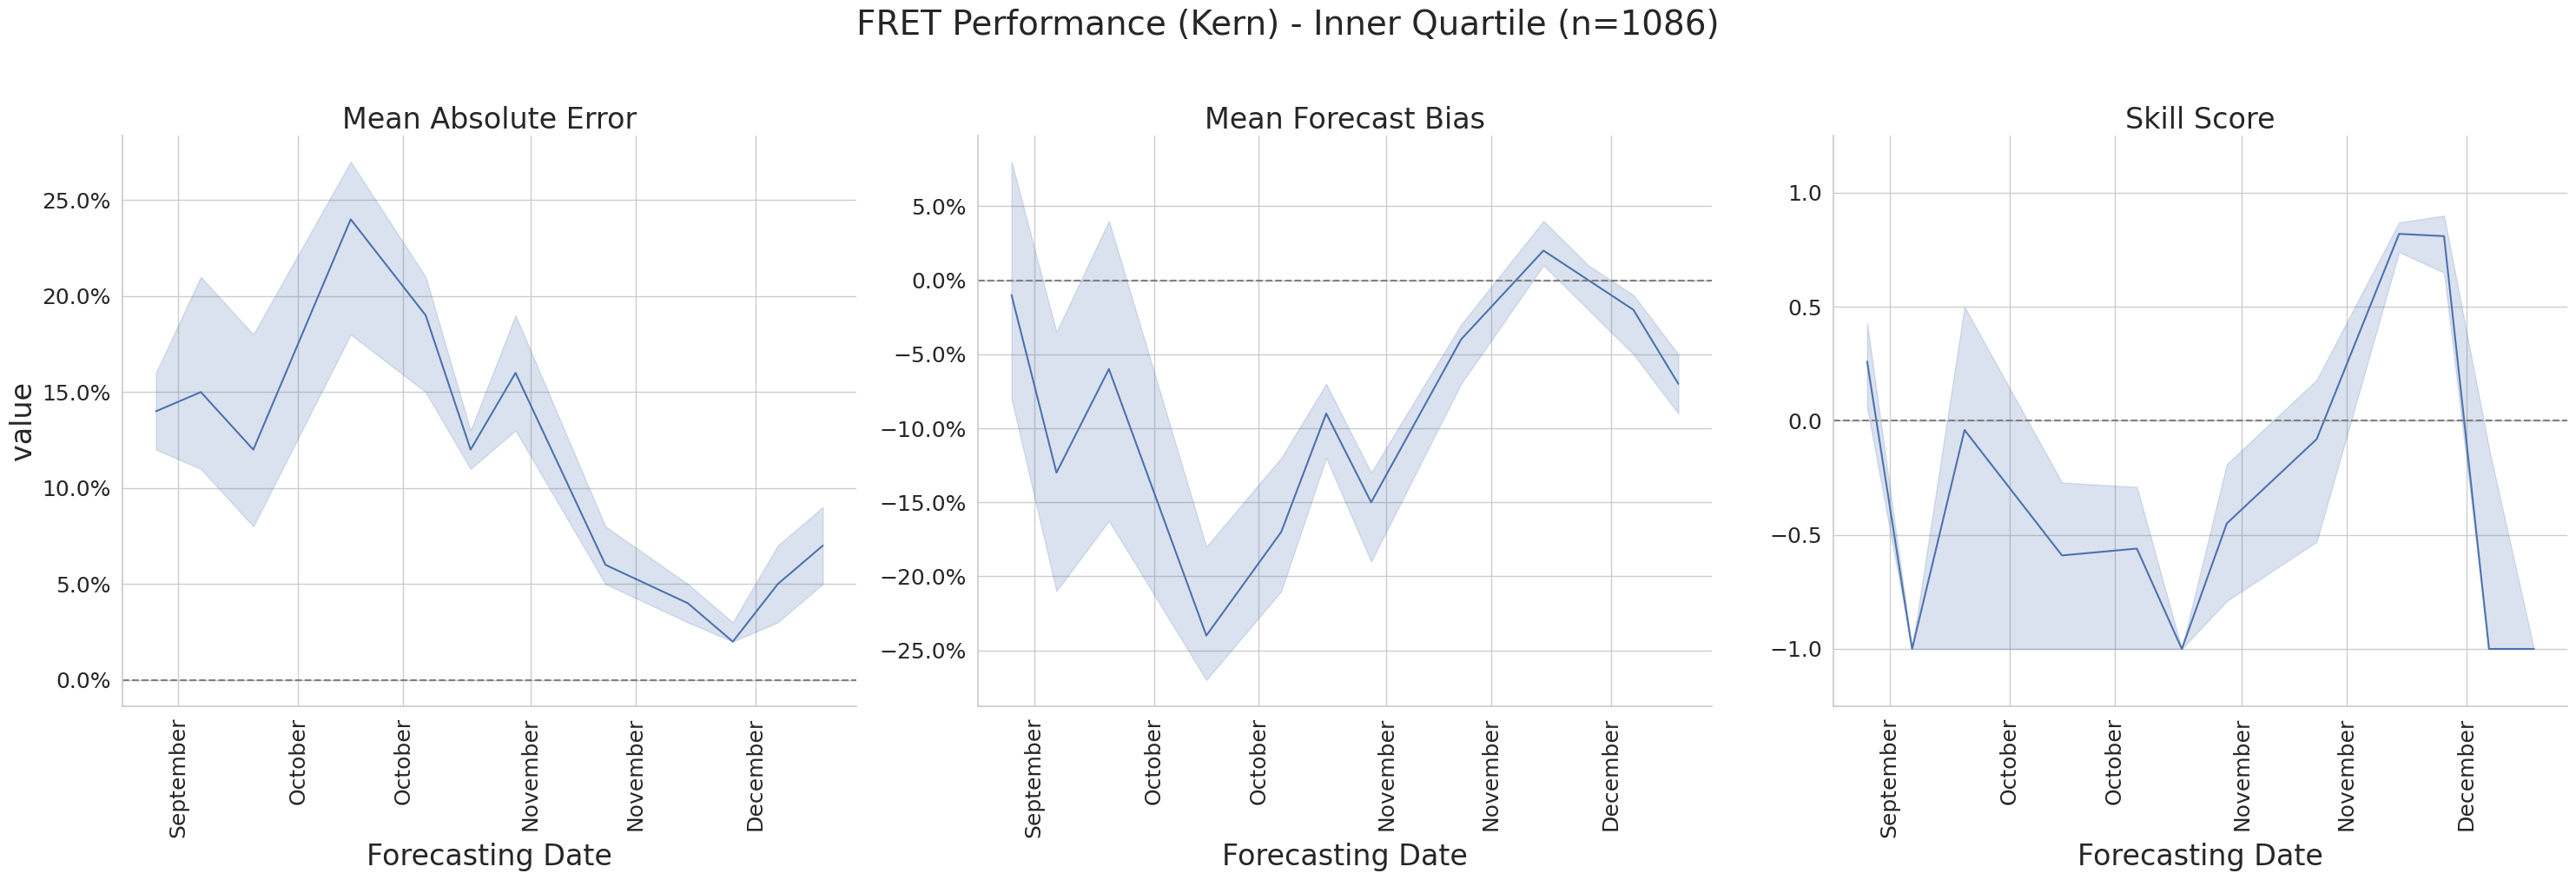

In [23]:
rel = timeseries_rel(metrics_long, col='name', y='value',
                     errorbar=('pi', 50), estimator=np.median, as_percent=True,
                     refline={'y': 0},
                     facet_kws={'sharey': False, 'margin_titles': True}, height=10,
                     title_template={"col_template":"{col_name}"},
                     title=f"FRET Performance (Kern) - Inner Quartile (n={metrics_long['field_id'].nunique()})");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));

### Notes
FRET has gathered almost weekly since the start of September 2024. On 2024 Oct 8, FRET was migrated to use polygon endpoints instead of point. 

MAE looks to have improved in performance between mid-October and the start of December. In Kern County, this is nearing the end of the harvest season. 

On average, bias was underforecasting by 8%. Interquartile range for bias was -1% to -14%. 

For most of the collection period, climatology is outscoring FRET except during the second half of November. 

In [27]:
metrics_norm[['mae', 'bias', 'skill_score']].describe().round(2)

,mae,bias,skill_score
count,13016.00,13016.00,13016.00
mean,0.12,-0.08,-0.30
std,0.08,0.10,0.70
min,0.01,-0.36,-1.00
25%,0.06,-0.14,-1.00
50%,0.10,-0.07,-0.43
75%,0.16,-0.01,0.32
max,0.97,0.97,0.98


## Comparison to Dynamic Time Warping

In [29]:
dtw_metrics = pd.read_csv('../data/metrics/kern_poly_metrics.csv', low_memory=False).drop(columns=['level_1', 'rmse', 'corr', 'c_mae', 'c_bias'])
dtw_metrics = dtw_metrics[dtw_metrics['variable'] == 'ETo']
dtw_metrics = dtw_metrics.drop(columns='variable')
dtw_metrics['forecasting_date'] = pd.to_datetime(dtw_metrics['forecasting_date'])

# Filters out dates not in FRET.
dtw_metrics = dtw_metrics[(dtw_metrics['forecasting_date'] >= metrics_norm['forecasting_date'].min()) & (dtw_metrics['forecasting_date'] <= metrics_norm['forecasting_date'].max())]

dtw_metrics['method'] = 'dtw'
dtw_metrics.head()

,forecasting_date,field_id,crop,mae,bias,skill_score,method
5600,2024-09-16,CA_298397,75,0.12,-0.00,-0.18,dtw
5601,2024-09-16,CA_299395,75,0.18,0.03,-1.00,dtw
5602,2024-09-16,CA_299467,75,0.18,0.03,-1.00,dtw
5603,2024-09-16,CA_300271,75,0.19,0.02,-1.00,dtw
5604,2024-09-16,CA_300581,75,0.19,0.03,-1.00,dtw


In [30]:
fret_metrics = metrics_norm[metrics_norm['field_id'].isin(dtw_metrics['field_id'].unique())].drop(columns=['rmse', 'corr', 'c_mae', 'c_bias'])
fret_metrics.loc[:, 'method'] = 'fret'
fret_metrics.head()

,forecasting_date,field_id,crop,mae,bias,skill_score,method
24,2024-09-12,CA_298397,75,0.14,-0.02,0.36,fret
75,2024-09-12,CA_299395,75,0.20,0.17,-0.33,fret
78,2024-09-12,CA_299467,75,0.18,-0.13,-0.03,fret
120,2024-09-12,CA_300271,75,0.07,0.01,0.77,fret
138,2024-09-12,CA_300581,75,0.06,0.01,0.81,fret


In [31]:
overview_cmp = pd.concat([dtw_metrics, fret_metrics])
overview_cmp

,forecasting_date,field_id,crop,mae,bias,skill_score,method
5600,2024-09-16,CA_298397,75,0.12,-0.00,-0.18,dtw
5601,2024-09-16,CA_299395,75,0.18,0.03,-1.00,dtw
5602,2024-09-16,CA_299467,75,0.18,0.03,-1.00,dtw
5603,2024-09-16,CA_300271,75,0.19,0.02,-1.00,dtw
5604,2024-09-16,CA_300581,75,0.19,0.03,-1.00,dtw
...,...,...,...,...,...,...,...
12959,2024-12-10,CA_41244,69,0.07,-0.07,-1.00,fret
12972,2024-12-10,CA_41458,69,0.09,-0.09,-1.00,fret
12983,2024-12-10,CA_41682,69,0.10,-0.09,-0.66,fret
13005,2024-12-10,CA_42021,69,0.06,-0.06,-1.00,fret


In [32]:
overview_cmp_long = overview_cmp.melt(id_vars=['forecasting_date', 'field_id', 'crop', 'method'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


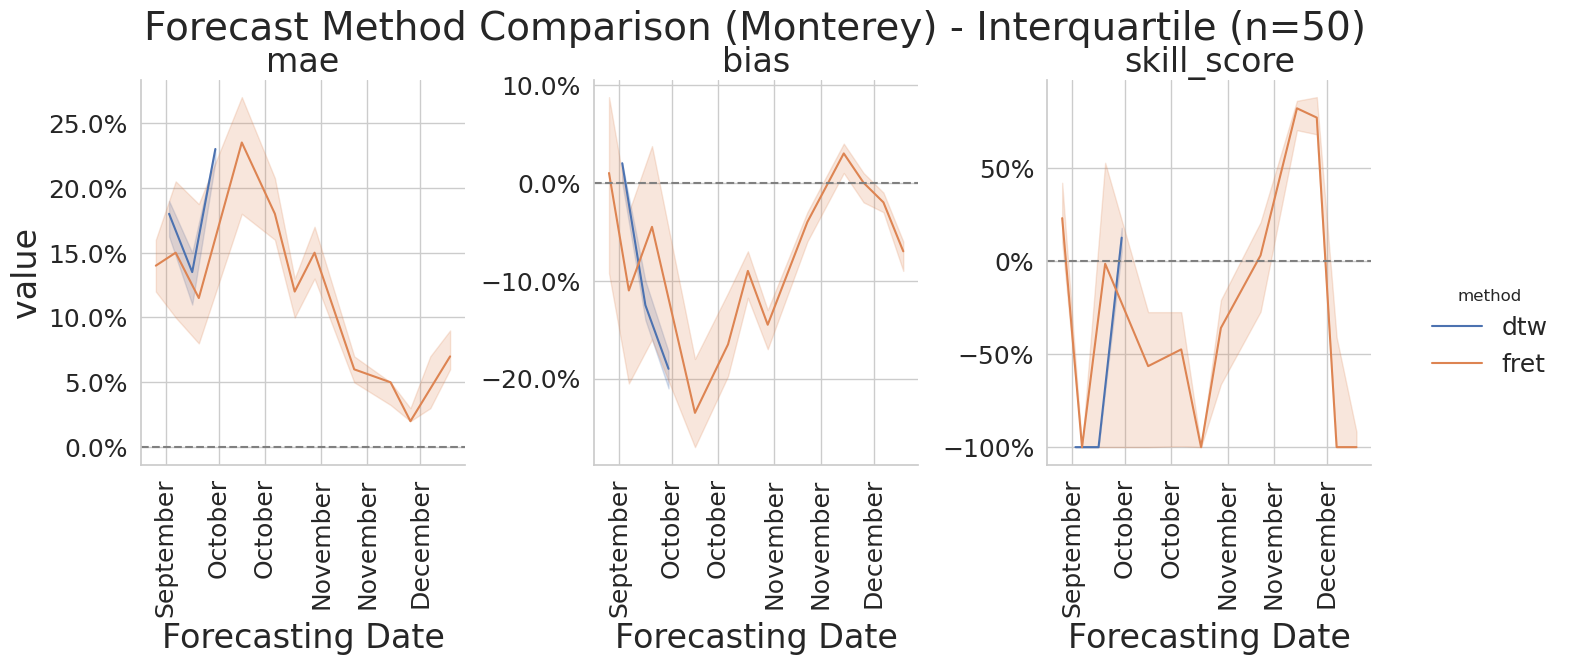

In [33]:
rel = timeseries_rel(overview_cmp_long, y='value', plot='rel', kind='line',
                     col='stat', hue='method',
                     refline={'y': 0},
                     facet_kws={'sharey': False, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.4, 'hspace': 0.2}}, 
                     estimator=np.median, errorbar=('pi', 50), 
                     title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title=f"Forecast Method Comparison (Monterey) - Interquartile (n={overview_cmp_long['field_id'].nunique()})", 
                     as_percent=True);